In [1]:
!pip install segyio
!pip install segmentation-models-3D
!pip install patchify
!pip install segysak

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 5.1 MB/s 


In [2]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import segyio
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import segmentation_models_3D as sm
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from segysak.segy import segy_header_scan, segy_header_scrape, get_segy_texthead, segy_loader
from keras.metrics import MeanIoU
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap

In [5]:
# tf.config.list_physical_devices() 

In [6]:
seismic_path = '/content/drive/MyDrive/synthteic_fault_dataset/seis'
fault_path = '/content/drive/MyDrive/synthteic_fault_dataset/fault'

In [7]:
seis_input = []
fault_output = []

for i in os.listdir(seismic_path)[:100]:
  seis_input.append(np.reshape(np.fromfile(seismic_path+'/'+i,dtype=np.single), (128, 128, 128))[18:114, 18:114, 18:114])
  fault_output.append(np.reshape(np.fromfile(fault_path+'/'+i,dtype=np.single), (128, 128, 128))[18:114, 18:114, 18:114])
  # seis_input.append(np.reshape(np.fromfile(seismic_path+'/'+i,dtype=np.single), (128, 128, 128)))
  # fault_output.append(np.reshape(np.fromfile(fault_path+'/'+i,dtype=np.single), (128, 128, 128)))


In [8]:
train_img = np.stack((seis_input,)*3, axis=-1)
train_mask = np.expand_dims(fault_output, axis=4)


train_mask_cat = tf.keras.utils.to_categorical(train_mask, num_classes=2)


X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.20, random_state = 0)

print(X_train.shape)
print(X_test.shape)

(80, 96, 96, 96, 3)
(20, 96, 96, 96, 3)


In [8]:
def normalize(gx):
  gm = np.mean(gx)
  gs = np.std(gx)
  gx = gx-gm
  gx = gx/gs
  return gx

In [10]:
X_train_norm = []
X_test_norm = []
for i in range(80):
  X_train_norm.append(normalize(X_train[i]))

for i in range(20):
  X_test_norm.append(normalize(X_test[i]))

X_train = np.array(X_train_norm)
X_test = np.array(X_test_norm)


In [5]:
#Define parameters for our model.

encoder_weights = 'imagenet'
BACKBONE = 'resnet50'
activation = 'sigmoid'
patch_size = 96
n_classes = 2
channels=3

LR = 0.001

metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]

In [6]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [14]:
model = sm.Unet(BACKBONE, classes=n_classes, 
                input_shape=(patch_size, patch_size, patch_size, channels), 
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = Adam(learning_rate=LR), loss=sm.losses.binary_focal_dice_loss, metrics=metrics)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 96, 96, 96,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, 96, 96, 96,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding3d (ZeroPadding3D)  (None, 102, 102, 10  0          ['bn_data[0][0]']                
                                2, 3)                                                       

In [15]:
#Fit the model
history = model.fit(X_train, 
                    y_train,
                    batch_size=8, 
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/100
10/10 [==============================] - 90s 3s/step - loss: 0.6181 - iou_score: 0.3585 - f1-score: 0.4544 - val_loss: 1.1919 - val_iou_score: 0.4567 - val_f1-score: 0.4822
Epoch 2/100
10/10 [==============================] - 26s 3s/step - loss: 0.5555 - iou_score: 0.4425 - f1-score: 0.5090 - val_loss: 1.1472 - val_iou_score: 0.4553 - val_f1-score: 0.4773
Epoch 3/100
10/10 [==============================] - 26s 3s/step - loss: 0.5507 - iou_score: 0.4443 - f1-score: 0.5129 - val_loss: 1.3214 - val_iou_score: 0.4322 - val_f1-score: 0.4719
Epoch 4/100
10/10 [==============================] - 26s 3s/step - loss: 0.5414 - iou_score: 0.4418 - f1-score: 0.5142 - val_loss: 1.2164 - val_iou_score: 0.4674 - val_f1-score: 0.4936
Epoch 5/100
10/10 [==============================] - 26s 3s/step - loss: 0.5250 - iou_score: 0.4536 - f1-score: 0.5295 - val_loss: 1.1257 - val_iou_score: 0.4595 - val_f1-score: 0.4790
Epoch 6/100
10/10 [==============================] - 26s 3s/step - loss: 0.

In [16]:
#  Save model for future use
model.save('/content/drive/MyDrive/Colab Notebooks/data/3D_fault_model_resnet50_100data_0.001LR_100epochs_adam.h5')

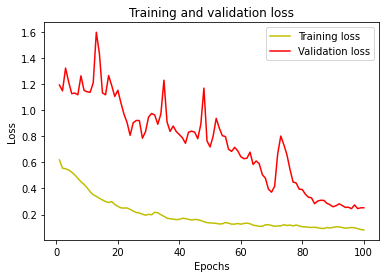

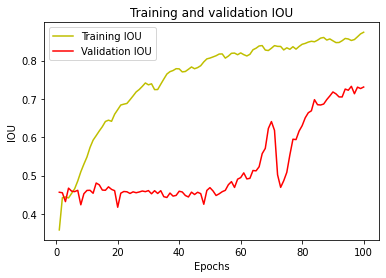

In [17]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [18]:
#Predict on the test data
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)

#Predict on the train data
y_pred_train=model.predict(X_train)
y_pred_train_argmax=np.argmax(y_pred_train, axis=4)
y_train_argmax = np.argmax(y_train, axis=4)

In [19]:
IOU_keras_train = MeanIoU(num_classes=n_classes)  
IOU_keras_train.update_state(y_train_argmax, y_pred_train_argmax)
print("Mean IoU Train=", IOU_keras_train.result().numpy())

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU Test=", IOU_keras.result().numpy())

Mean IoU Train= 0.85335934
Mean IoU Test= 0.74338245


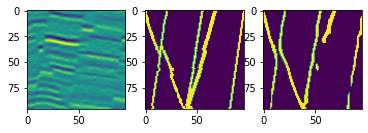

In [20]:
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
randil = np.random.randint(0, len(X_test), 1)[0]
ax1.imshow(X_test[randil, 29, : , :, 1].T)
ax2.imshow(y_test_argmax[randil, 29, : , :].T)
ax3.imshow(y_pred_argmax[randil, 29, : , :].T)

In [9]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/data/3D_fault_model_resnet50_100data_0.001LR_100epochs_adam.h5', compile=False)

In [6]:
val_input = segyio.tools.cube('/content/drive/MyDrive/synthteic_fault_dataset/sepat_crop.segy')[:,:,384:960]

In [7]:
val_input.shape

(480, 960, 576)

In [28]:
patches = patchify(val_input, (96, 96, 96), step=96)
print(val_input.shape)
print(patches.shape)

(480, 960, 576)
(5, 10, 6, 96, 96, 96)


In [34]:

predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      single_patch = patches[i,j,k, :,:,:]
      single_patch = normalize(single_patch)
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_prediction = model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [35]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)

(5, 10, 6, 96, 96, 96)


In [36]:
reconstructed_seismic = unpatchify(predicted_patches_reshaped, val_input.shape)
print(reconstructed_seismic.shape)

(480, 960, 576)


In [10]:
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
color_array[:,-1] = np.linspace(0.0,0,ncolors)
color_array[255:256] = [1, 0.0, 0., 1]
map_object = LinearSegmentedColormap.from_list(name='fault',colors=color_array)
plt.register_cmap(cmap=map_object)

In [44]:
vm = np.percentile(val_input, 99)

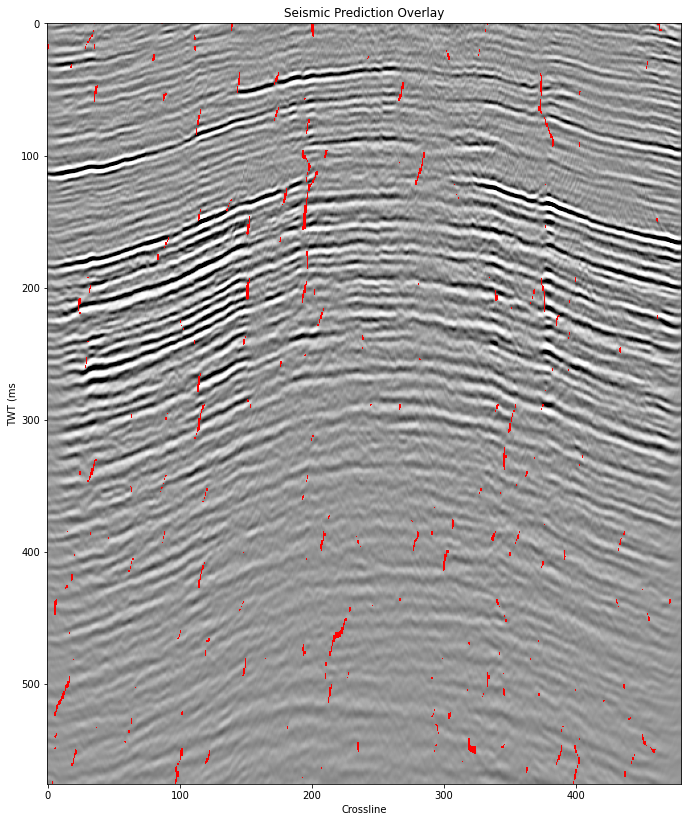

In [45]:
plt.figure(figsize=(20, 14))
plt.imshow(val_input[:, 750, :].T, cmap='Greys', vmin=-vm, vmax=vm)
plt.imshow(reconstructed_seismic[:, 750, :].T, cmap='fault')
plt.title('Seismic Prediction Overlay')
plt.xlabel('Crossline')
plt.ylabel('TWT (ms')
plt.show()

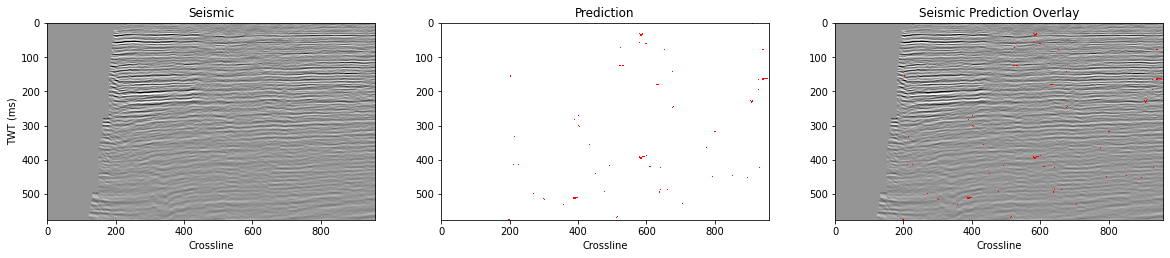

In [46]:
plt.figure(figsize=(20, 14))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.imshow(val_input[231, :, :].T, cmap='Greys', vmin=-vm, vmax=vm)
ax2.imshow(reconstructed_seismic[231, :, :].T,  cmap='fault')
ax3.imshow(val_input[231, :, :].T, cmap='Greys', vmin=-vm, vmax=vm)
ax3.imshow(reconstructed_seismic[231, :, :].T, cmap='fault')

ax1.set_title('Seismic')
ax2.set_title('Prediction')
ax3.set_title('Seismic Prediction Overlay')
ax1.set_xlabel('Crossline')
ax2.set_xlabel('Crossline')
ax3.set_xlabel('Crossline')
ax1.set_ylabel('TWT (ms)')
ax1.set_ylabel('TWT (ms)')
ax1.set_ylabel('TWT (ms)')
plt.show()

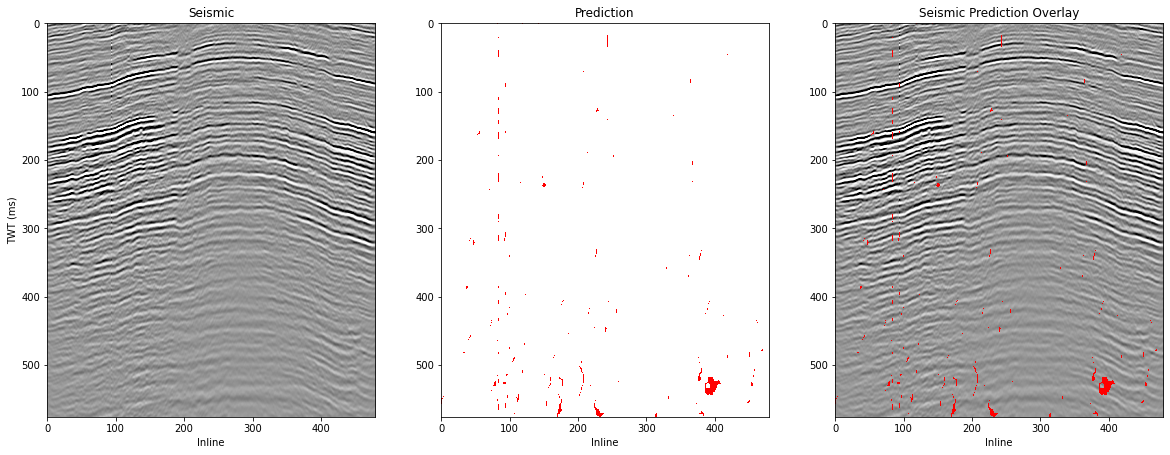

In [47]:
plt.figure(figsize=(20, 14))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.imshow(val_input[:,367, :].T, cmap='Greys', vmin=-vm, vmax=vm)
ax2.imshow(reconstructed_seismic[:, 367, :].T,  cmap='fault')
ax3.imshow(val_input[:, 367, :].T, cmap='Greys', vmin=-vm, vmax=vm)
ax3.imshow(reconstructed_seismic[:, 367, :].T, cmap='fault')

ax1.set_title('Seismic')
ax2.set_title('Prediction')
ax3.set_title('Seismic Prediction Overlay')
ax1.set_xlabel('Inline')
ax2.set_xlabel('Inline')
ax3.set_xlabel('Inline')
ax1.set_ylabel('TWT (ms)')
ax1.set_ylabel('TWT (ms)')
ax1.set_ylabel('TWT (ms)')
plt.show()

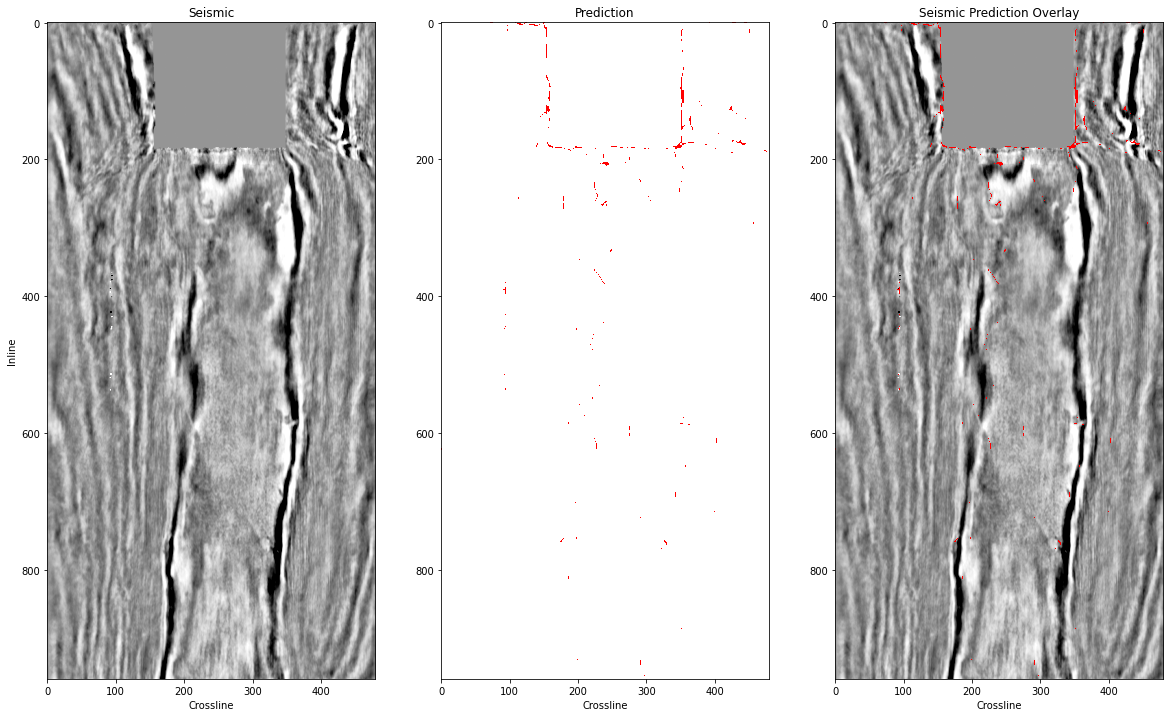

In [48]:
plt.figure(figsize=(20, 14))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.imshow(val_input[:, :, 125].T, cmap='Greys', vmin=-vm, vmax=vm)
ax2.imshow(reconstructed_seismic[:, :, 125].T,  cmap='fault')
ax3.imshow(val_input[:, :, 125].T, cmap='Greys', vmin=-vm, vmax=vm)
ax3.imshow(reconstructed_seismic[:, :, 125].T, cmap='fault')

ax1.set_title('Seismic')
ax2.set_title('Prediction')
ax3.set_title('Seismic Prediction Overlay')
ax1.set_xlabel('Crossline')
ax2.set_xlabel('Crossline')
ax3.set_xlabel('Crossline')
ax1.set_ylabel('Inline')
ax1.set_ylabel('Inline')
ax1.set_ylabel('Inline')
plt.show()

In [11]:
!wget http://s3.amazonaws.com/open.source.geoscience/open_data/newzealand/Taranaiki_Basin/Keri_3D/Kerry3D.segy

--2022-06-20 10:08:50--  http://s3.amazonaws.com/open.source.geoscience/open_data/newzealand/Taranaiki_Basin/Keri_3D/Kerry3D.segy
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.171.224
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.171.224|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1107042960 (1.0G) [application/octet-stream]
Saving to: ‘Kerry3D.segy’

Kerry3D.segy        100%[===================>]   1.03G  67.0MB/s    in 17s     

2022-06-20 10:09:08 (61.4 MB/s) - ‘Kerry3D.segy’ saved [1107042960/1107042960]



In [12]:
get_segy_texthead('/content/Kerry3D.segy')

Text HeaderC01 AREA        : OFFSHORE TARANAKI - OFFSHORE TARANAKI SEISMIC DATABASE
C02 DESCRIPTION : KERRY3D SEISMIC COVERAGE - PHASE MATCHED IN GEOFRAME
C03 ===========================================================================
C04 DATE     :1996       CLASS      :RAW MIGRATION /+90 DEGREE PHASE SHIFT
C05 OPERATOR :WMC        PROCESSING :DIGICON SINGAPORE
C06 ===========================================================================
C07 THE 3D DATA HAS BEEN DATUM AND PHASE SHIFTED. DATA HAS BEEN MERGED WITH
C08 CHECKED NAV AND EXPORTED FROM GEOFRAME 4.2 IN STANDARD SEGY.
C09 INLINES/SP RANGE :510-796 CDP INC       :1        SAMPLE INTERVAL :4000
C10 XLINES/CDP RANGE :58-792  SAMPLES/TRACE :1251     FINAL TIME :5000
C11 LINE INC      :1  TRACES/LINE   :VARIABLE IL/XL X/EAST Y/NORTH
C12 ===========================================================================
C13 THIS DATASET WAS PREPARED AND COMPILED BY THE INSITITUE OF GEOLOGICAL
C14 AND NUCLEAR SCIENCES LIMITED (GNS SCIENCE), 1 FAIRWAY DRIVE,
C15 LOWER HUTT, NEW ZEALAND. FUNDING FOR THIS PROJECT WAS PROVIDED BY THE
C16 FOUNDATION FOR RESEARCH, SCIENCE AND TECHNOLOGY: CO5X0302 AND CO5X0905.
C17
C18 THIS DATA IS PROVIDED ON A "AS IS" BASIS AND ALTHOUGH DATA HAS BEEN
C19 MODIFIED BY GNS SCIENCE, NO WARRANTY, EXPRESSED OR IMPLIED, IS MADE BY
C20 GNS SCIENCE AS TO THE ACCURACY OF THE DATA OR RELATED MATERIALS, ITS
C21 COMPLETENESS OR FITNESS FOR PURPOSE. IN NO EVENT WILL GNS SCIENCE, ITS
C22 EMPLOYEES, AGENTS OR CONTRACTORS BE LIABLE FOR ANY LOSS COSTS OR DAMAGE
C23 ARISING FROM ANY PARTIES USE OR RELIANCE ON THE DATASET INCLUDING ANY
C24 CONSEQUENTIAL, SPECIAL, INDIRECT, INCIDENTAL, PUNITIVE OR EXEMPLARY
C25 DAMAGES, COSTS, EXPENSES OR LOSSES. GNS SCIENCE WILL NOT ACCEPT ANY
C26 LIABILITY FOR THE CONSEQUENCES OF ANY PARTY ACTING ON THIS INFORMATION.
C27 ===========================================================================
C28 BYTE LOCATIONS :      SURVEY GEOMETRY    SURVEY/DATA PARAMETERS
C29 LINE      :BYTES 221  MIN Line :510      DATA TYPE  :SEGY
C30 CDP       :BYTES 21   MAX Line :796      MEDIA No   :E02337 - E02342
C31 SOURCE X  :BYTES 73   MIN CDP  :58       PROJECTION :NZTM
C32 SOURCE Y  :BYTES 77   MAX CDP  :792      DATUM      :NZGD2000
C33 ===========================================================================
C34 POINTS USED FOR        LINE 510  CDP 58        LINE 792  CDP 796
C35 SURVEY DEFINITION:     1703638   5571677       1689838   5608539
C36                        LINE 510  CDP 792
C37                        1704135   5608346
C38 DATE CREATED: 1 FEB 2010
C39 USER: P.VISKOVIC
C40

In [16]:
with segyio.open('/content/Kerry3D.segy', 'r', iline=73, xline=21) as segyfile:
    data = segyio.tools.cube(segyfile)
    ntraces = segyfile.tracecount
    sr = segyio.tools.dt(segyfile)
    nsamples = segyfile.samples.size
    twt = segyfile.samples + 1000
    size_mb= data.nbytes/1024**2
    inlines = segyfile.ilines
    crosslines = segyfile.xlines
    header = segyio.tools.wrap(segyfile.text[0])

In [22]:
val_input = data[:96, :576, :1248]

In [23]:
patches = patchify(val_input, (96, 96, 96), step=96)
print(val_input.shape)
print(patches.shape)

(96, 576, 1248)
(1, 6, 13, 96, 96, 96)


In [24]:

predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      single_patch = patches[i,j,k, :,:,:]
      single_patch = normalize(single_patch)
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_prediction = model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)

In [25]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)

(1, 6, 13, 96, 96, 96)


In [26]:
reconstructed_seismic = unpatchify(predicted_patches_reshaped, val_input.shape)
print(reconstructed_seismic.shape)

(96, 576, 1248)


In [27]:
vm = np.percentile(val_input, 99)

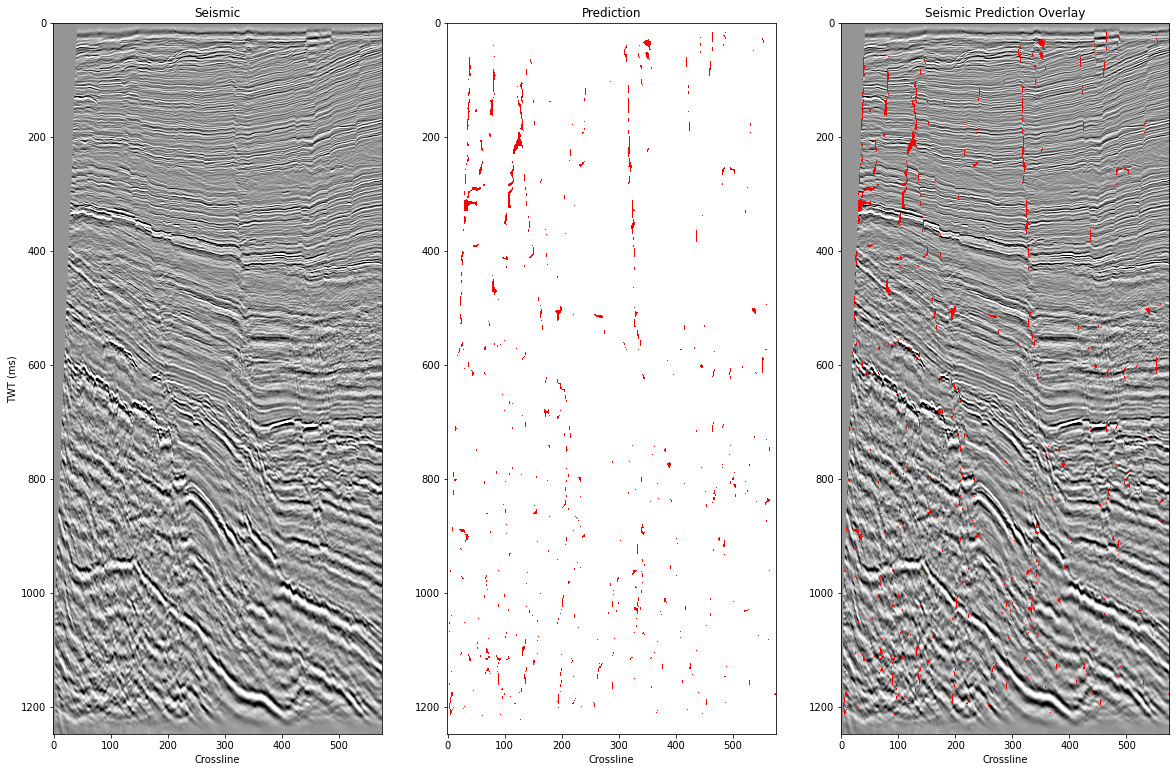

In [31]:
plt.figure(figsize=(20, 14))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.imshow(val_input[31, :, :].T, cmap='Greys', vmin=-vm, vmax=vm)
ax2.imshow(reconstructed_seismic[31, :, :].T,  cmap='fault')
ax3.imshow(val_input[31, :, :].T, cmap='Greys', vmin=-vm, vmax=vm)
ax3.imshow(reconstructed_seismic[31, :, :].T, cmap='fault')

ax1.set_title('Seismic')
ax2.set_title('Prediction')
ax3.set_title('Seismic Prediction Overlay')
ax1.set_xlabel('Crossline')
ax2.set_xlabel('Crossline')
ax3.set_xlabel('Crossline')
ax1.set_ylabel('TWT (ms)')
ax1.set_ylabel('TWT (ms)')
ax1.set_ylabel('TWT (ms)')
plt.show()

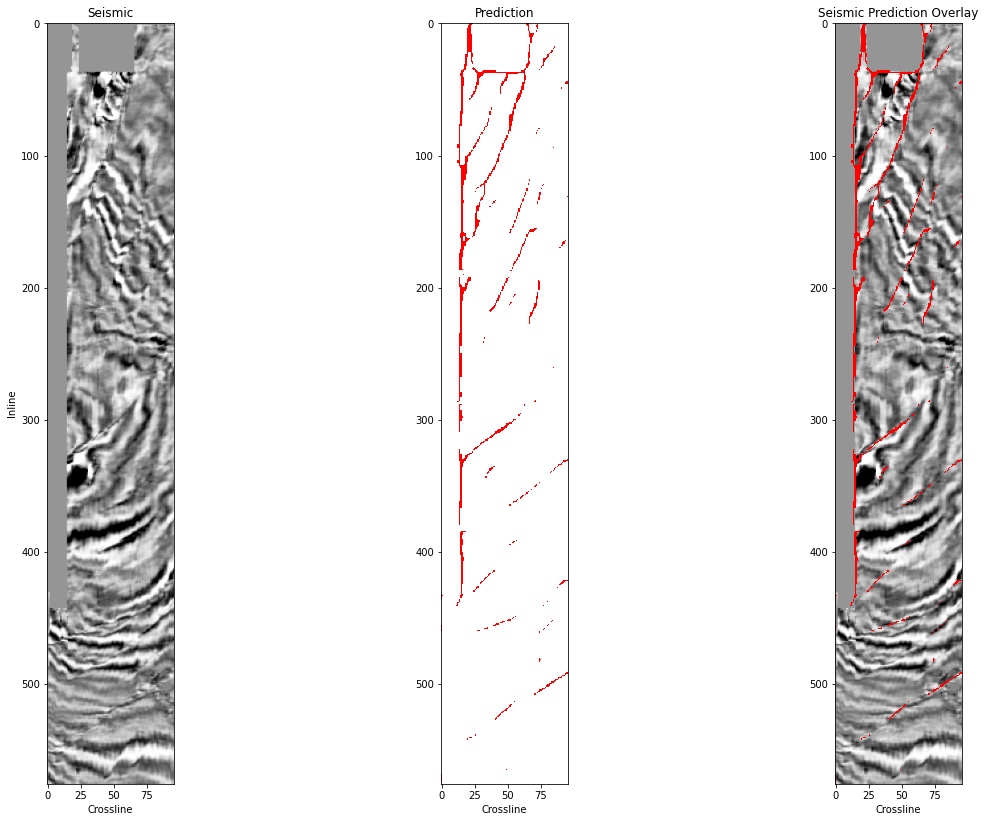

In [36]:
plt.figure(figsize=(20, 14))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.imshow(val_input[:, :, 125].T, cmap='Greys', vmin=-vm, vmax=vm)
ax2.imshow(reconstructed_seismic[:, :, 125].T,  cmap='fault')
ax3.imshow(val_input[:, :, 125].T, cmap='Greys', vmin=-vm, vmax=vm)
ax3.imshow(reconstructed_seismic[:, :, 125].T, cmap='fault')

ax1.set_title('Seismic')
ax2.set_title('Prediction')
ax3.set_title('Seismic Prediction Overlay')
ax1.set_xlabel('Crossline')
ax2.set_xlabel('Crossline')
ax3.set_xlabel('Crossline')
ax1.set_ylabel('Inline')
ax1.set_ylabel('Inline')
ax1.set_ylabel('Inline')
plt.show()